## Explore telecom users dataset and build predictive models for churn

## Table of Contents
* Import and Preprocessing
* Explore feature distributions
* Explore Target and Impact of each Feature
* Model - Random Forest
* Model - Gradient Boosting
* Individuals with highest likelihood to churn

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Imports

In [3]:
# packages

# standard
import numpy as np
import pandas as pd
import time

# plots
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# statistics tools
from statsmodels.graphics.mosaicplot import mosaic



In [4]:
# ML tools
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator

## Data Preprocessing

### load data

In [5]:

df = pd.read_csv('telecom_users.csv')
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [6]:
df.shape

(5986, 22)

#### Some initial clean up first

In [7]:
# conversions
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce') # has some string values, force them to NaN
df.SeniorCitizen = df.SeniorCitizen.astype('object')

# drop first column
df = df.drop('Unnamed: 0', axis=1)

In [8]:
# show structure of data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5986 non-null   object 
 1   gender            5986 non-null   object 
 2   SeniorCitizen     5986 non-null   object 
 3   Partner           5986 non-null   object 
 4   Dependents        5986 non-null   object 
 5   tenure            5986 non-null   int64  
 6   PhoneService      5986 non-null   object 
 7   MultipleLines     5986 non-null   object 
 8   InternetService   5986 non-null   object 
 9   OnlineSecurity    5986 non-null   object 
 10  OnlineBackup      5986 non-null   object 
 11  DeviceProtection  5986 non-null   object 
 12  TechSupport       5986 non-null   object 
 13  StreamingTV       5986 non-null   object 
 14  StreamingMovies   5986 non-null   object 
 15  Contract          5986 non-null   object 
 16  PaperlessBilling  5986 non-null   object 


Unfortunately there are 10 missings for "TotalCharges". Let's check those guys.

In [9]:
df[df.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
634,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
2771,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
3086,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
3255,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
4326,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
5375,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
5382,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5695,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
5951,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No


Ok, this is easier than expected. In all those cases tenure = 0, so we can set the TotalCharges to 0 as well.

In [10]:
df.TotalCharges = df.TotalCharges.fillna(0)

## Feature Engg.

In [11]:
# define numerical features
features_num = ['tenure','MonthlyCharges','TotalCharges']

In [12]:
# define categorical features
features_cat = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies',
                'Contract', 'PaperlessBilling','PaymentMethod']

### EDA of Numerical Features

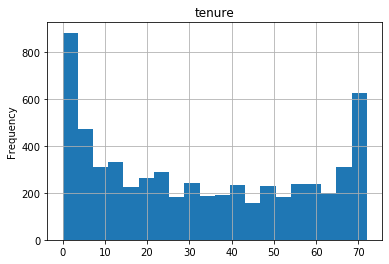

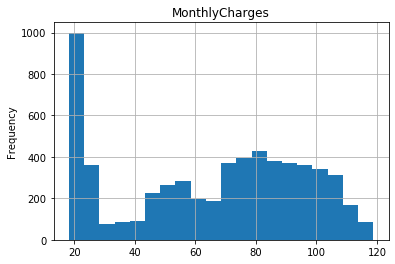

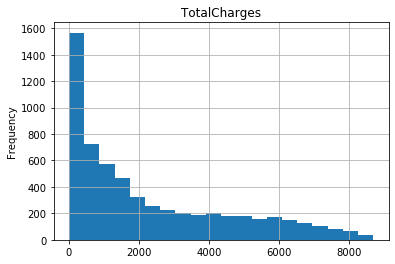

In [13]:
# plot numerical distributions
for f in features_num:
    df[f].plot(kind='hist', bins=20)
    plt.title(f)
    plt.grid()
    plt.show()

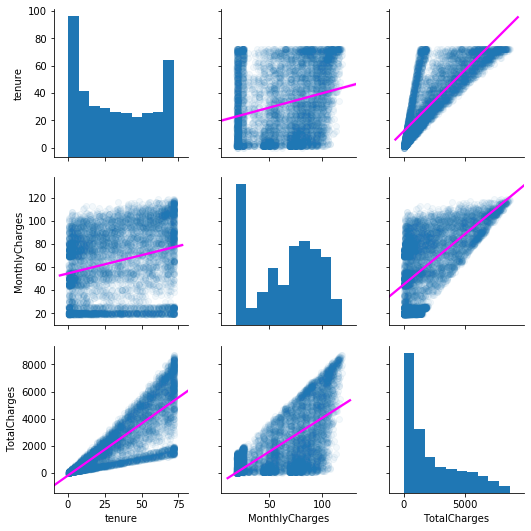

In [14]:
# pairwise scatter plot
sns.pairplot(df[features_num], 
             kind='reg', 
             plot_kws={'line_kws':{'color':'magenta'}, 'scatter_kws': {'alpha': 0.05}})
plt.show()

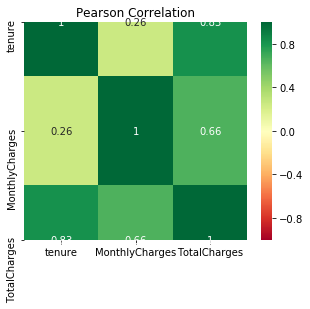

In [15]:
# Pearson (linear) correlation
corr_pearson = df[features_num].corr(method='pearson')

fig = plt.figure(figsize = (5,4))
sns.heatmap(corr_pearson, annot=True, cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('Pearson Correlation')
plt.show()

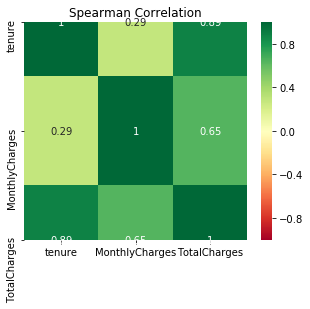

In [16]:
# Spearman (Rank) correlation
corr_spearman = df[features_num].corr(method='spearman')

fig = plt.figure(figsize = (5,4))
sns.heatmap(corr_spearman, annot=True, cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('Spearman Correlation')
plt.show()

### EDA of Categorical Features

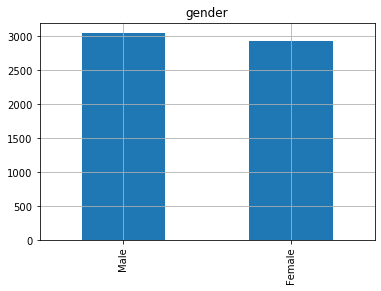

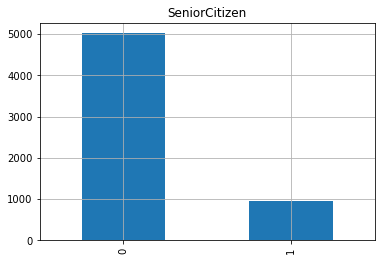

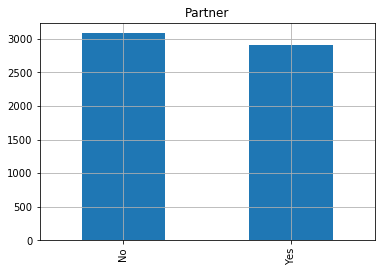

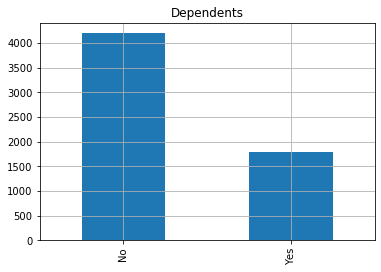

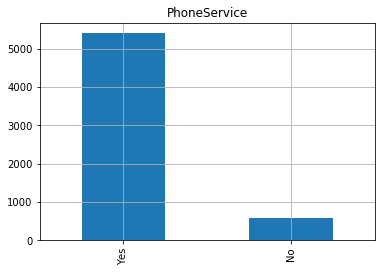

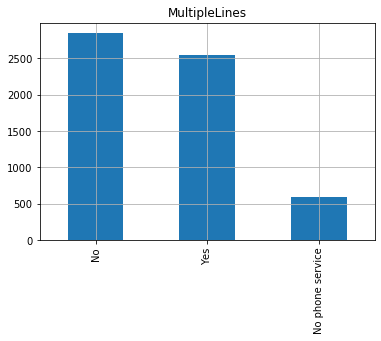

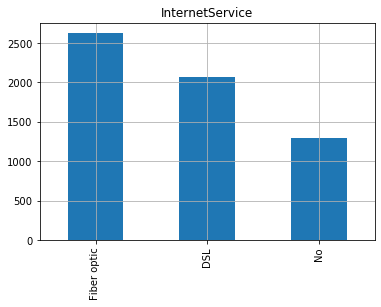

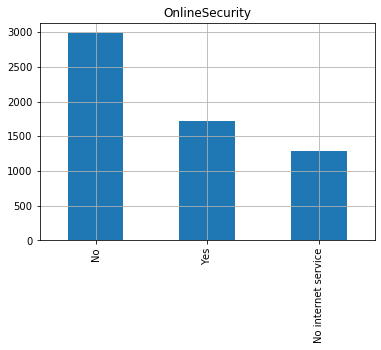

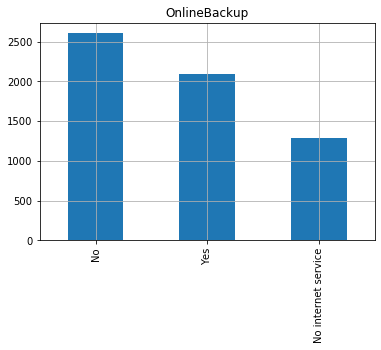

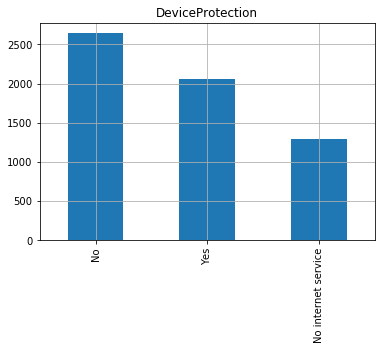

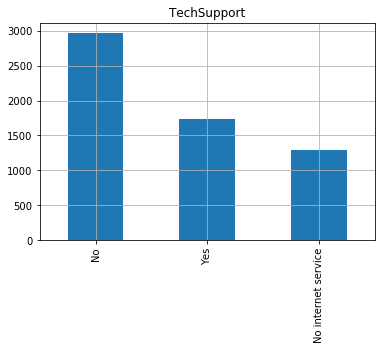

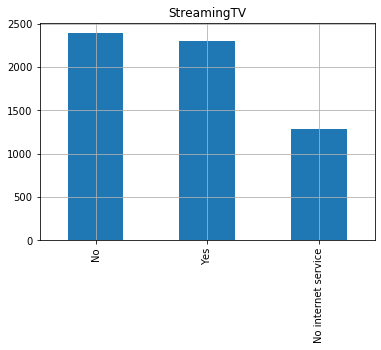

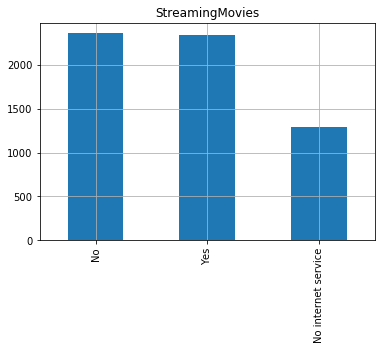

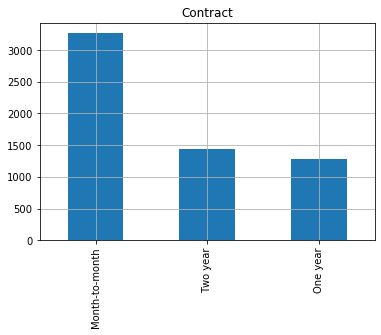

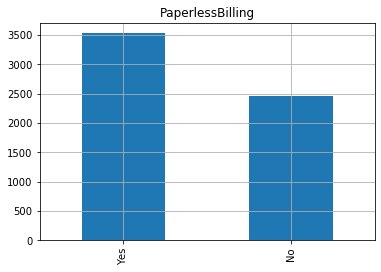

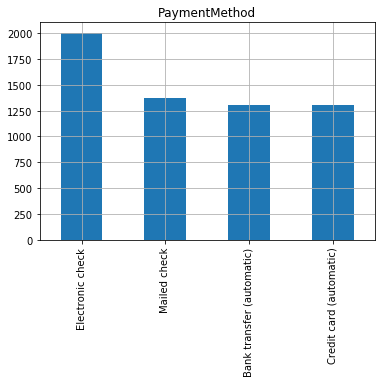

In [17]:
# plot categorical distributions
for f in features_cat:
    df[f].value_counts().plot(kind='bar')
    plt.title(f)
    plt.grid()
    plt.show()

## Explore Target and Impact of each Feature

In [18]:
target = 'Churn'

No     4399
Yes    1587
Name: Churn, dtype: int64


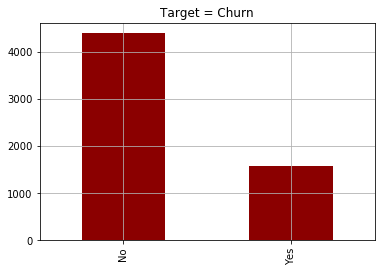

In [19]:
# eval frequencies
print(df[target].value_counts())
# and plot
df[target].value_counts().plot(kind='bar', color='darkred')
plt.title('Target = Churn')
plt.grid()
plt.show()

### Target vs Numerical Features

In [18]:
# add binned version of numerical features for plotting

# quantile based:
df['BIN_tenure'] = pd.qcut(df['tenure'], q=10, precision=1)
df['BIN_MonthlyCharges'] = pd.qcut(df['MonthlyCharges'], q=10, precision=1)
df['BIN_TotalCharges'] = pd.qcut(df['TotalCharges'], q=10, precision=1)

Let's use mosaic plots to show the impact of the binned features on the target:

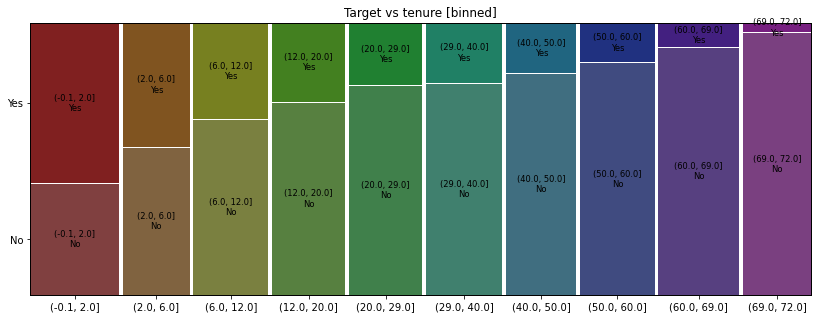

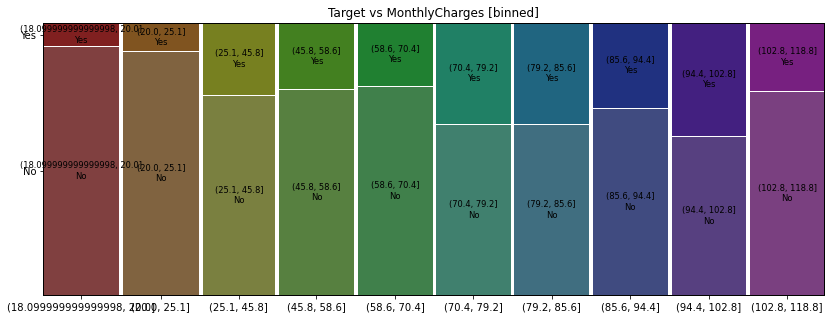

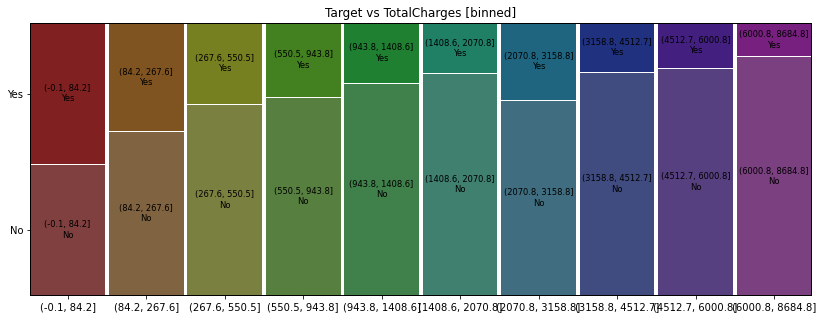

In [19]:
# plot target vs features using mosaic plot
plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in features_num:
    f_bin = 'BIN_' + f
    plt.rcParams['figure.figsize'] = (14,5) # increase plot size for mosaics
    mosaic(df, [f_bin, target], title='Target vs ' + f + ' [binned]')
    plt.show()
    
# reset plot size again
plt.rcParams['figure.figsize'] = plt_para_save

### Interpretations: Churn probability decreases with tenure and (more or less) increases with monthly charge.

## Target vs Categorical Features

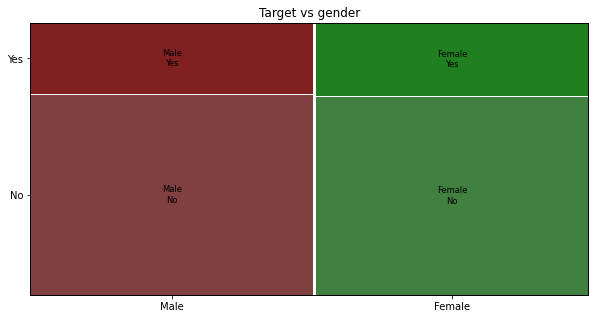

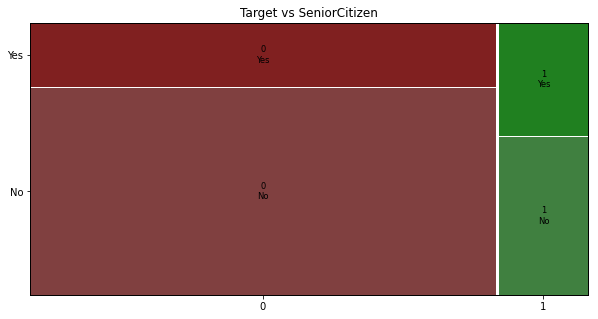

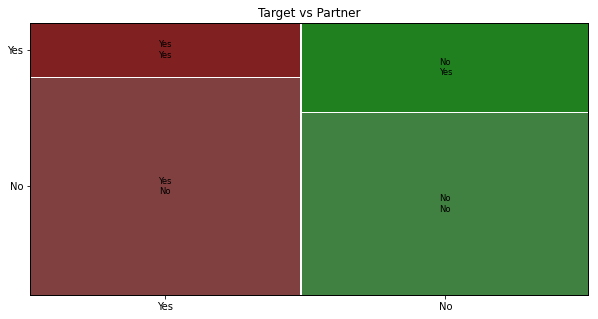

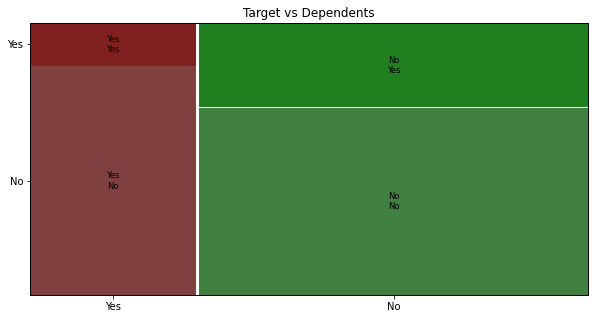

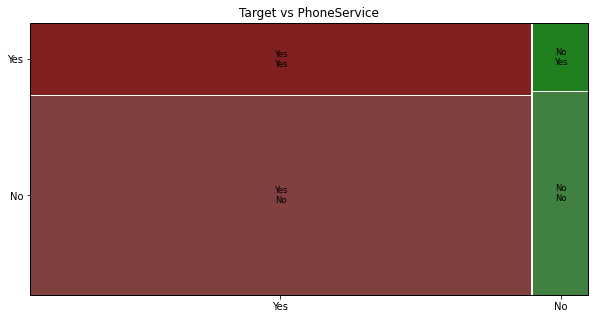

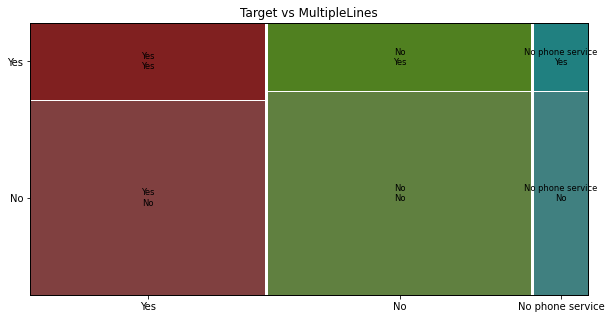

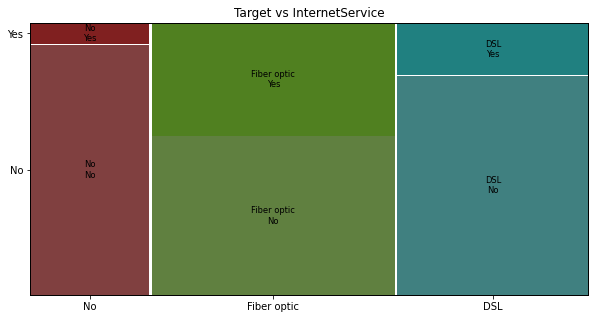

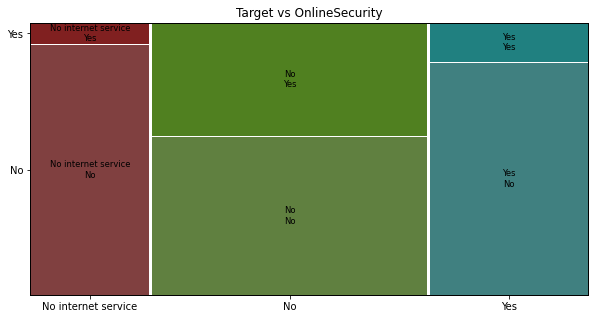

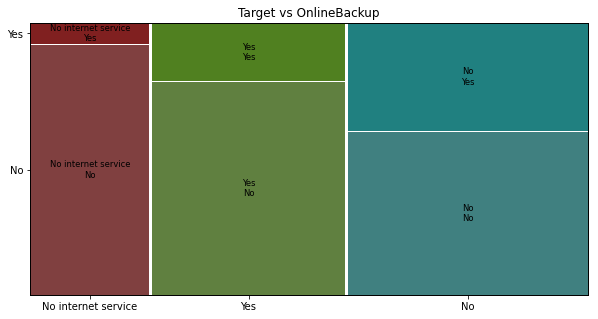

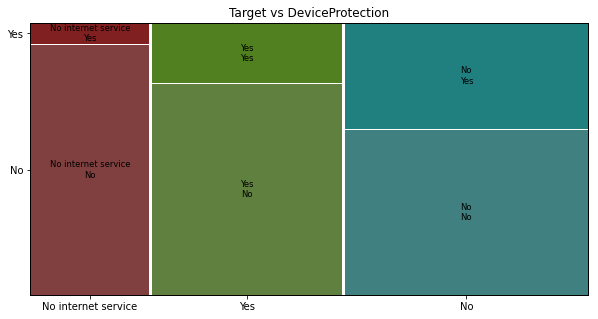

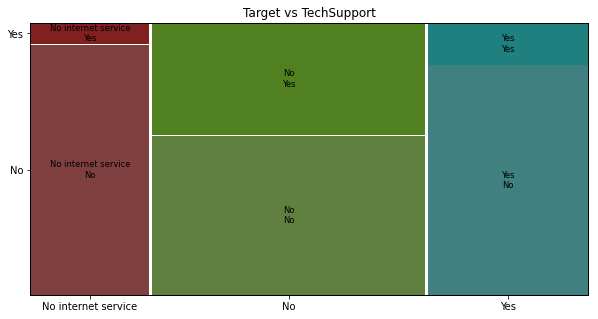

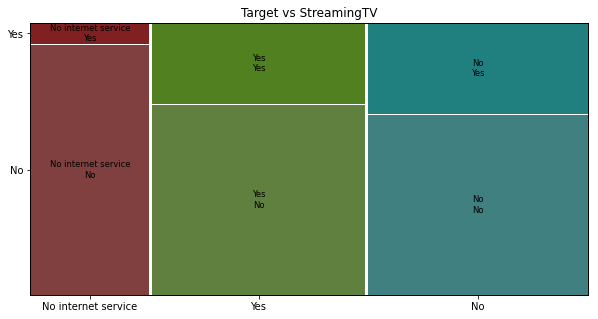

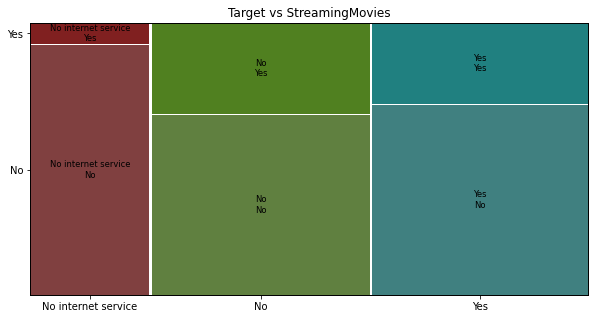

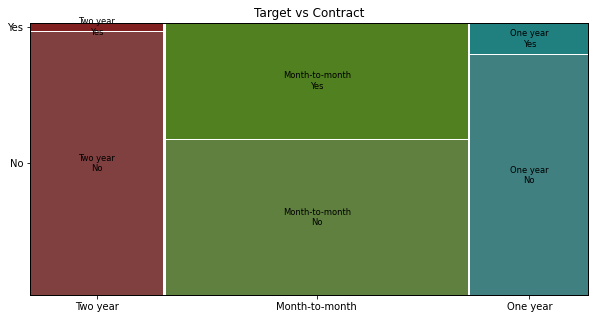

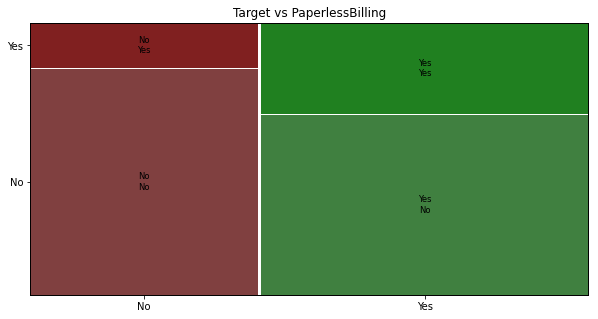

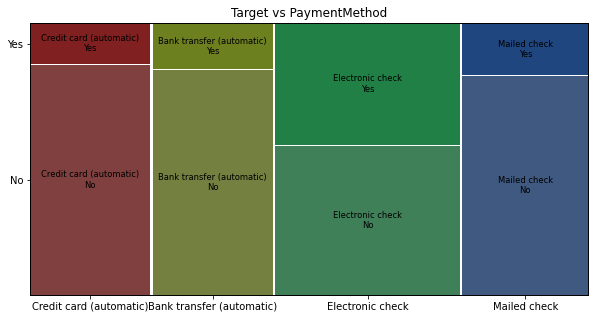

In [20]:
# plot target vs features using mosaic plot
plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in features_cat:
    plt.rcParams['figure.figsize'] = (10,5) # increase plot size for mosaics
    mosaic(df, [f, target], title='Target vs ' + f)
    plt.show()
    
# reset plot size again
plt.rcParams['figure.figsize'] = plt_para_save

### A few interpretations: Gender does not really seem to matter, whereas "SeniorCitizen", "Partner" and "Dependents" do make a difference. No internet services seem to imply a low churn risk. High impact of month-to-month payments and electronic check payment etc.

## Model - Random Forest

In [21]:
# select predictors
predictors = features_num + features_cat
print('Number of predictors: ', len(predictors))
print(predictors)

Number of predictors:  19
['tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [22]:
# start H2O
h2o.init(max_mem_size='12G', nthreads=4) # Use maximum of 12 GB RAM and 4 cores

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpj3ovqul5
  JVM stdout: /tmp/tmpj3ovqul5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpj3ovqul5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_unknownUser_gyvjh3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [23]:
# upload data frame in H2O environment
df_hex = h2o.H2OFrame(df)

# train / test split (70/30)
train_hex, test_hex = df_hex.split_frame(ratios=[0.7], seed=999)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [24]:
# define (distributed) Random Forest model
n_CV = 5 # cross validations

fit_1 = H2ORandomForestEstimator(ntrees=50,
                                   max_depth=15,
                                   min_rows=5,
                                   nfolds=n_CV,
                                   model_id='DRF_1',
                                   seed=999)

In [25]:
# train model
t1 = time.time()
fit_1.train(x=predictors,
            y=target,
            training_frame=train_hex)
t2 = time.time()
print('Elapsed time [s]: ', np.round(t2-t1,2))

drf Model Build progress: |███████████████████████████████████████████████| 100%
Elapsed time [s]:  14.87


In [26]:
# show cross validation metrics
fit_1.cross_validation_metrics_summary()


Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7849855,0.016984591,0.8006873,0.79908675,0.78520286,0.7586207,0.78132993
1,auc,0.8481809,0.008783011,0.84614486,0.84404445,0.85447925,0.85924524,0.8369908
2,aucpr,0.6712709,0.016159695,0.6679747,0.64854294,0.6937001,0.67501634,0.67112046
3,err,0.2150145,0.016984591,0.19931272,0.20091324,0.21479714,0.2413793,0.21867007
4,err_count,180.8,12.8335495,174.0,176.0,180.0,203.0,171.0
5,f0point5,0.6005069,0.019708324,0.62918836,0.60844374,0.59303975,0.57625145,0.5956113
6,f1,0.6473191,0.014909634,0.66015625,0.6255319,0.6498054,0.6611018,0.64
7,f2,0.7046638,0.047916252,0.69433033,0.6436077,0.71858865,0.7752545,0.69153774
8,lift_top_group,3.5537567,0.26151595,3.3021276,3.5196428,3.8796296,3.3077679,3.7596154
9,logloss,0.41813612,0.014927948,0.41960883,0.40987992,0.3990324,0.43885842,0.423301



See the whole table with table.as_data_frame()


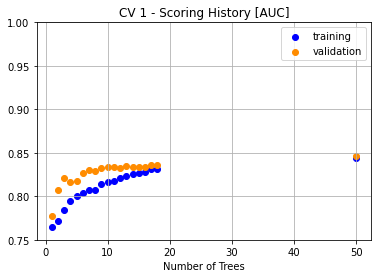

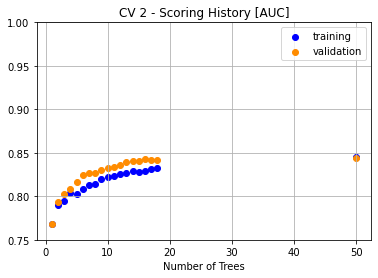

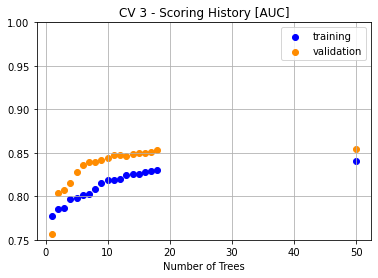

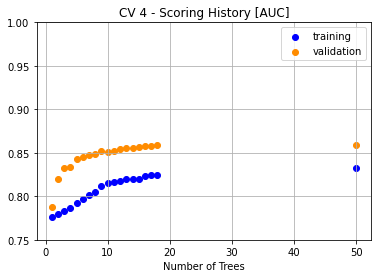

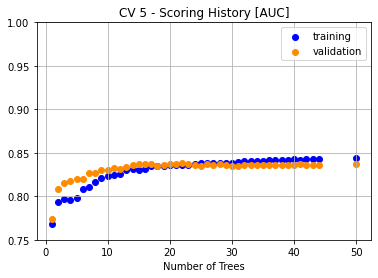

In [27]:
# show scoring history - training vs cross validations
for i in range(n_CV):
    cv_model_temp = fit_1.cross_validation_models()[i]
    df_cv_score_history = cv_model_temp.score_history()
    my_title = 'CV ' + str(1+i) + ' - Scoring History [AUC]'
    plt.scatter(df_cv_score_history.number_of_trees,
                y=df_cv_score_history.training_auc, 
                c='blue', label='training')
    plt.scatter(df_cv_score_history.number_of_trees,
                y=df_cv_score_history.validation_auc, 
                c='darkorange', label='validation')
    plt.title(my_title)
    plt.xlabel('Number of Trees')
    plt.ylim(0.75,1)
    plt.legend()
    plt.grid()
    plt.show()

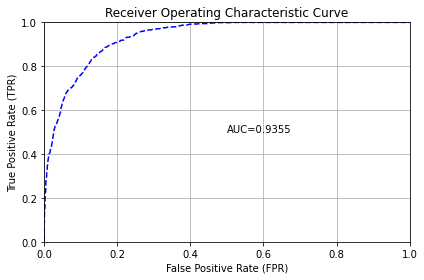

In [28]:
# calc performance on TRAINING data
perf_train_1 = fit_1.model_performance(train_hex)
# ROC curve
perf_train_1.plot()

In [29]:
# predict on training data
pred_train_1 = fit_1.predict(train_hex)
# and check calibration (using class probabilities)
print('Predicted frequency:', pred_train_1['Yes'].sum())
print('Actual frequency   :', train_hex[target].sum())

drf prediction progress: |████████████████████████████████████████████████| 100%
Predicted frequency: 1111.9300690925133
Actual frequency   : 1109.0


In [30]:
# confusion matrix using manual threshold
# => our goal is to approximately match actual and predicted values
tt_1 = 0.4165
conf_train_1 = perf_train_1.confusion_matrix(thresholds=tt_1)
conf_train_1.show()

Could not find exact threshold 0.4165; using closest threshold found 0.41646200338999434.

Confusion Matrix (Act/Pred) @ threshold = 0.41646200338999434: 


,,No,Yes,Error,Rate
0,No,2819.0,282.0,0.0909,(282.0/3101.0)
1,Yes,280.0,829.0,0.2525,(280.0/1109.0)
2,Total,3099.0,1111.0,0.1335,(562.0/4210.0)


### Nicely calibrated: 1111 predicted churns vs. 1109 actual ones...

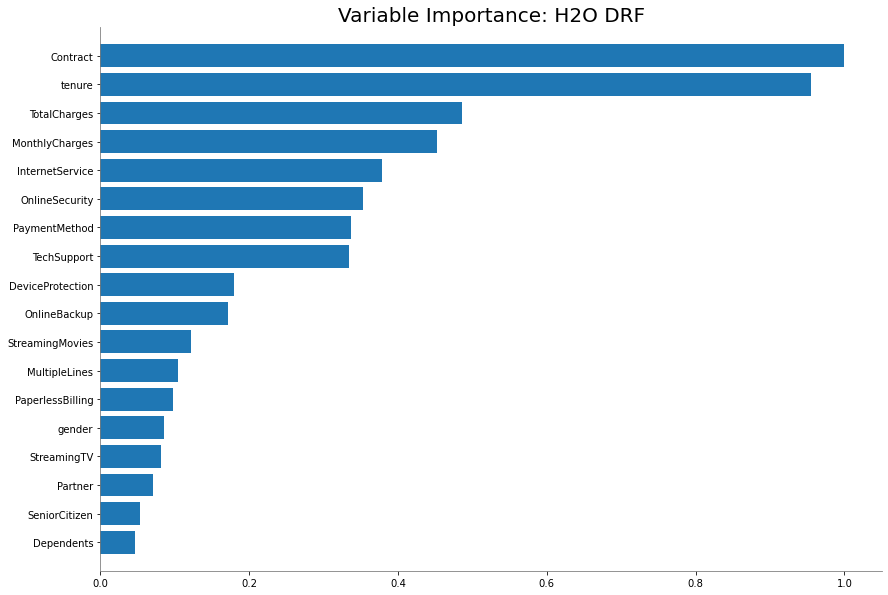

In [31]:
# show standard variable importance
fit_1.varimp_plot(-1)

Elapsed time [s]:  13.95


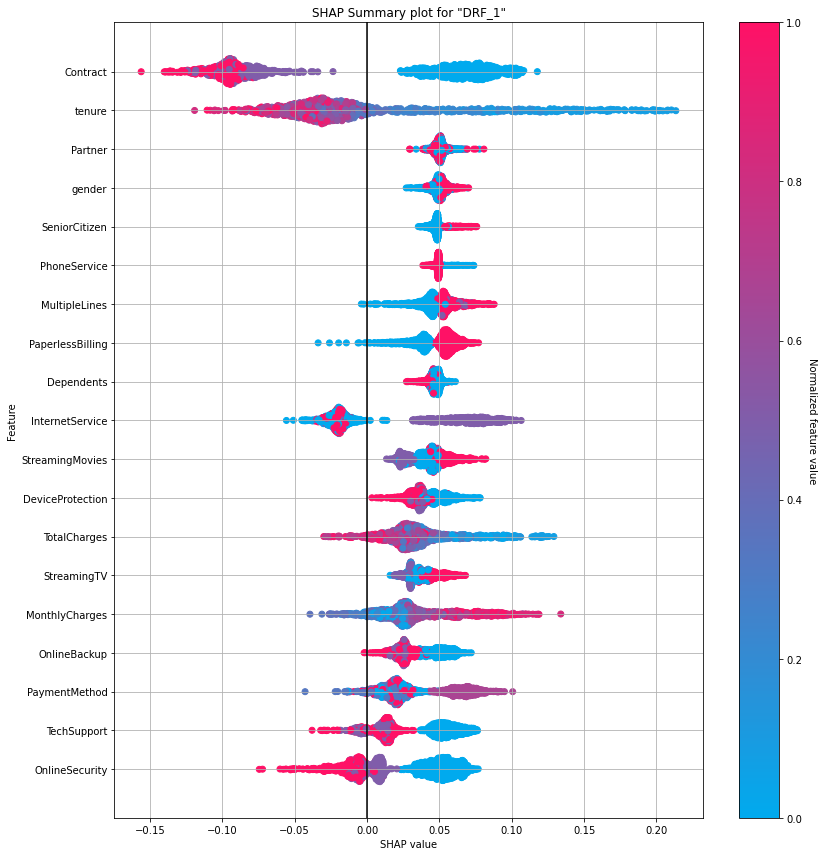

In [32]:
# variable importance using SHAP values
# => see direction as well as severity of feature impact
t1 = time.time()
fit_1.shap_summary_plot(train_hex);
t2 = time.time()
print('Elapsed time [s]: ', np.round(t2-t1,2))

#### Now the real check on the test set:

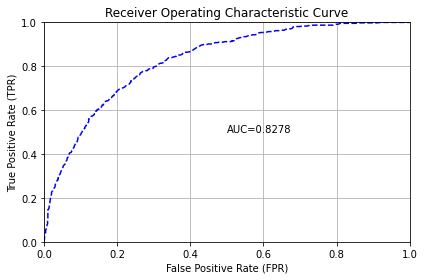

In [33]:
# calc performance on TEST test
perf_test_1 = fit_1.model_performance(test_hex)
# ROC curve
perf_test_1.plot()

In [34]:
# confusion matrix using manual threshold (from training)
conf_test_1 = perf_test_1.confusion_matrix(thresholds=tt_1)
conf_test_1.show()

Could not find exact threshold 0.4165; using closest threshold found 0.415908067325751.

Confusion Matrix (Act/Pred) @ threshold = 0.415908067325751: 


,,No,Yes,Error,Rate
0,No,1110.0,188.0,0.1448,(188.0/1298.0)
1,Yes,192.0,286.0,0.4017,(192.0/478.0)
2,Total,1302.0,474.0,0.214,(380.0/1776.0)


Still nice fit also on test set: 474 predicted churns vs 478 actual ones.

## Model - Gradient Boosting

In [35]:
# define Gradient Boosting model
fit_2 = H2OGradientBoostingEstimator(ntrees = 50,
                                     max_depth=4,
                                     min_rows=5,
                                     learn_rate=0.05,
                                     sample_rate=1,
                                     col_sample_rate=0.7,
                                     nfolds=n_CV,
                                     model_id='GBM_1',
                                     seed=999)

In [36]:
# train model
t1 = time.time()
fit_2.train(x=predictors,
            y=target,
            training_frame=train_hex)
t2 = time.time()
print('Elapsed time [s]: ', np.round(t2-t1,2))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Elapsed time [s]:  7.49


In [37]:
# show cross validation metrics
fit_2.cross_validation_metrics_summary()


Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7744934,0.028592283,0.79839635,0.73173517,0.8031026,0.76813316,0.77109975
1,auc,0.85311794,0.007780067,0.8529047,0.8477966,0.85919076,0.8622491,0.84344846
2,aucpr,0.6726046,0.018490795,0.67249864,0.6440832,0.6931839,0.68363804,0.6696192
3,err,0.22550659,0.028592283,0.20160367,0.26826483,0.19689737,0.23186682,0.22890025
4,err_count,190.0,27.349588,176.0,235.0,165.0,195.0,179.0
5,f0point5,0.5893757,0.036376763,0.6254417,0.53416485,0.61912227,0.5853051,0.58284456
6,f1,0.6499226,0.016602233,0.6679245,0.6263911,0.65696466,0.6584939,0.63983905
7,f2,0.7270467,0.026129095,0.71659917,0.75710994,0.6997343,0.7526021,0.7091882
8,lift_top_group,3.4510758,0.2515282,3.3021276,3.4761906,3.8796296,3.3077679,3.2896636
9,logloss,0.4107642,0.008553889,0.41659102,0.41065696,0.39955178,0.40583238,0.42118877



See the whole table with table.as_data_frame()


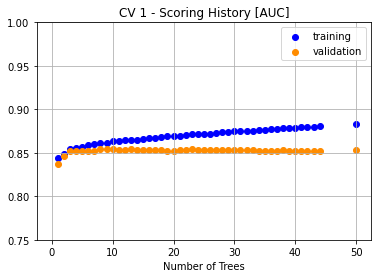

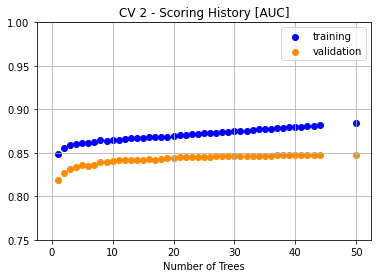

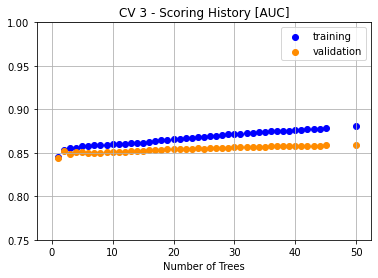

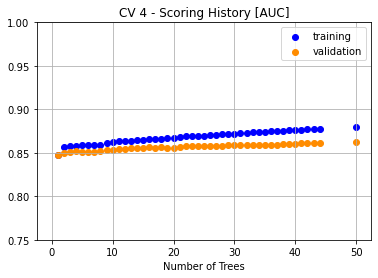

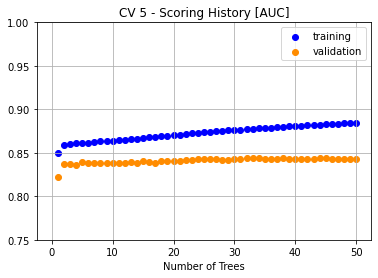

In [38]:
# show scoring history - training vs cross validations
for i in range(n_CV):
    cv_model_temp = fit_2.cross_validation_models()[i]
    df_cv_score_history = cv_model_temp.score_history()
    my_title = 'CV ' + str(1+i) + ' - Scoring History [AUC]'
    plt.scatter(df_cv_score_history.number_of_trees,
                y=df_cv_score_history.training_auc, 
                c='blue', label='training')
    plt.scatter(df_cv_score_history.number_of_trees,
                y=df_cv_score_history.validation_auc, 
                c='darkorange', label='validation')
    plt.title(my_title)
    plt.ylim(0.75,1)
    plt.xlabel('Number of Trees')
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
# predict on training data
pred_train_2 = fit_2.predict(train_hex)
# and check calibration
print('Predicted frequency:', pred_train_2['Yes'].sum())
print('Actual frequency   :', train_hex[target].sum())

gbm prediction progress: |████████████████████████████████████████████████| 100%
Predicted frequency: 1110.5905610054672
Actual frequency   : 1109.0


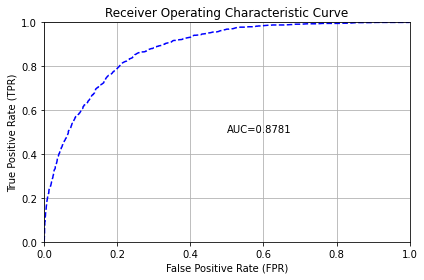

In [40]:
# calc performance on TRAINING data
perf_train_2 = fit_2.model_performance(train_hex)
# ROC curve
perf_train_2.plot()

In [41]:
# confusion matrix using manual threshold
# => our goal is to approximately match actual and predicted values
tt_2 = 0.417
conf_train_2 = perf_train_2.confusion_matrix(thresholds=tt_2)
conf_train_2.show()

Could not find exact threshold 0.417; using closest threshold found 0.417496010735802.

Confusion Matrix (Act/Pred) @ threshold = 0.417496010735802: 


,,No,Yes,Error,Rate
0,No,2715.0,386.0,0.1245,(386.0/3101.0)
1,Yes,388.0,721.0,0.3499,(388.0/1109.0)
2,Total,3103.0,1107.0,0.1838,(774.0/4210.0)


Nicely calibrated: 1107 predicted churns vs. 1109 actual ones...

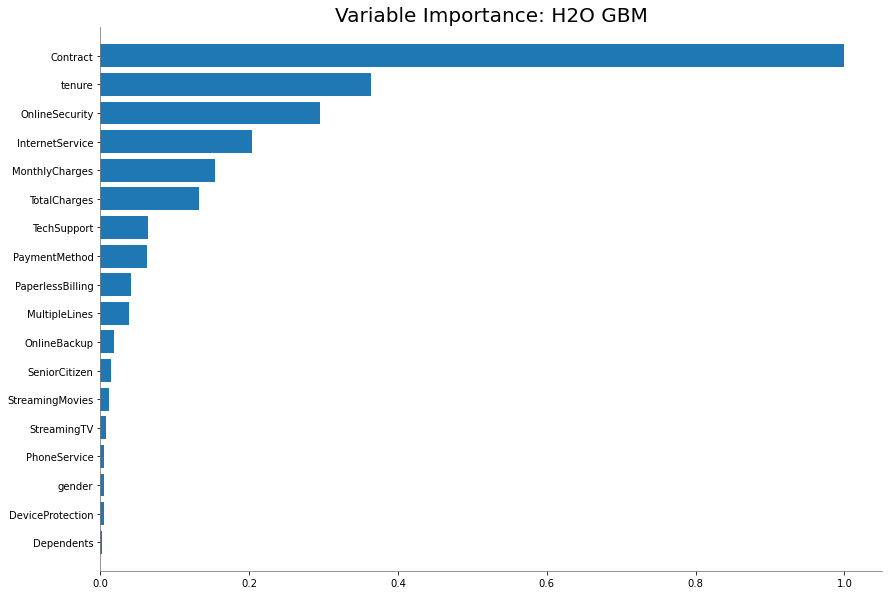

In [42]:
# show standard variable importance
fit_2.varimp_plot(-1)

Now again the real check on the test set:

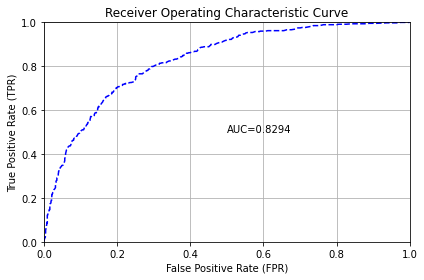

In [43]:
# calc performance on TEST test
perf_test_2 = fit_2.model_performance(test_hex)
# ROC Curve
perf_test_2.plot()

> Slightly better Test AUC than Random Forest model...

In [44]:
# confusion matrix using our manual threshold
conf_test_2 = perf_test_2.confusion_matrix(thresholds=tt_2)
conf_test_2.show()

Could not find exact threshold 0.417; using closest threshold found 0.4171150191749466.

Confusion Matrix (Act/Pred) @ threshold = 0.4171150191749466: 


,,No,Yes,Error,Rate
0,No,1113.0,185.0,0.1425,(185.0/1298.0)
1,Yes,197.0,281.0,0.4121,(197.0/478.0)
2,Total,1310.0,466.0,0.2151,(382.0/1776.0)


However, the results on the test set are a little bit more skewed: 466 predicted churns vs. 478 actual ones...

# Individuals with highest likelihood to churn

## We focus on the test set in the following!

In [45]:
# pull test set from H2O environment in pandas world
df_test = test_hex.as_data_frame()

# cosmetics: remove binned versions of numerical features
df_test = df_test.drop(['BIN_tenure','BIN_MonthlyCharges','BIN_TotalCharges'], axis=1)

# predict on test set (both models)
pred_test_1 = fit_1.predict(test_hex).as_data_frame()
pred_test_2 = fit_2.predict(test_hex).as_data_frame()

# and add prediction to test data frame
df_test['pred_churn_RF'] = pred_test_1.Yes
df_test['pred_churn_GB'] = pred_test_2.Yes

# add also blend of both models
df_test['pred_churn_blend'] = 0.5*pred_test_1.Yes + 0.5*pred_test_2.Yes

# show preview
df_test.head()

drf prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,pred_churn_RF,pred_churn_GB,pred_churn_blend
0,4312-GVYNH,Female,0,Yes,No,70,No,No phone service,DSL,Yes,...,Yes,Two year,Yes,Bank transfer (automatic),49.85,3370.20,No,0.014278,0.050201,0.032240
1,2495-KZNFB,Female,0,No,No,33,Yes,Yes,Fiber optic,Yes,...,Yes,Month-to-month,Yes,Electronic check,90.65,2989.60,No,0.370203,0.328289,0.349246
2,8898-KASCD,Male,0,No,No,39,No,No phone service,DSL,No,...,No,One year,No,Mailed check,35.55,1309.15,No,0.052556,0.083911,0.068233
3,2091-MJTFX,Female,0,Yes,Yes,30,No,No phone service,DSL,No,...,Yes,Month-to-month,No,Credit card (automatic),51.20,1561.50,Yes,0.202289,0.216965,0.209627
4,2511-MORQY,Male,0,Yes,Yes,50,Yes,Yes,DSL,No,...,No,One year,No,Bank transfer (automatic),54.90,2614.10,No,0.045799,0.091460,0.068630


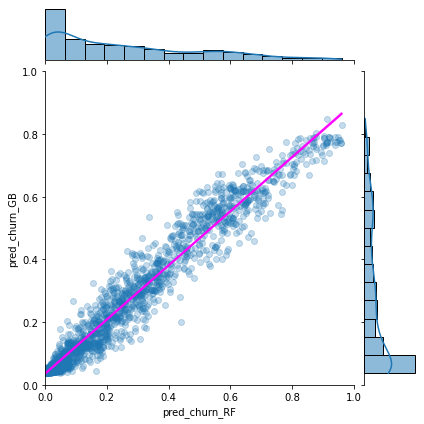

In [46]:
# compare predictions of both models
sns.jointplot(data=df_test, x='pred_churn_RF', y='pred_churn_GB',
              kind='reg',
              joint_kws = {'scatter_kws' : {'alpha' : 0.25}, 
                           'line_kws' : {'color' : 'magenta'}},
              xlim=(0,1),ylim=(0,1))
plt.show()

In [47]:
# our top 10 risks (in the test set) according to blend of models
top10 = df_test.nlargest(10, columns='pred_churn_blend')
top10

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,pred_churn_RF,pred_churn_GB,pred_churn_blend
13,9300-AGZNL,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,Yes,Month-to-month,Yes,Electronic check,94.00,94.00,Yes,0.960348,0.830210,0.895279
15,7216-EWTRS,Female,1,Yes,No,1,Yes,Yes,Fiber optic,No,...,Yes,Month-to-month,Yes,Electronic check,100.80,100.80,Yes,0.913058,0.849036,0.881047
300,7439-DKZTW,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,80.55,80.55,No,0.949784,0.789119,0.869451
1387,8740-CRYFY,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,78.95,78.95,Yes,0.955498,0.781522,0.868510
602,4424-TKOPW,Male,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,Month-to-month,Yes,Electronic check,93.85,196.75,Yes,0.951377,0.781162,0.866269
1254,6457-USBER,Male,0,No,No,1,Yes,No,Fiber optic,No,...,Yes,Month-to-month,Yes,Electronic check,80.80,80.80,Yes,0.940638,0.790900,0.865769
1288,0488-GSLFR,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,69.50,69.50,Yes,0.957476,0.771464,0.864470
1583,9728-FTTVZ,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,69.20,69.20,Yes,0.957476,0.771464,0.864470
488,3428-XZMAZ,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,69.35,69.35,Yes,0.945488,0.775502,0.860495
768,7254-IQWOZ,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,69.65,69.65,Yes,0.938821,0.775502,0.857162
